# Reconstruction - **Trajectory on deformed lane**

In [61]:
import pandas as pd
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

Here the idea is to take the coordinates already transformed and convert them into the new reference system

In [62]:
VIDEO_NUMBER = "5"
PROJECT_ROOT = Path().resolve().parent.parent
CSV_POINTS_POSITIONS_FILE_PATH = str(
    PROJECT_ROOT
    / "data"
    / "auxiliary_data"
    / "reconstructed_positions"
    / f"Transformed_positions_processed_{VIDEO_NUMBER}.csv"
)
CSV_POINTS_POSITIONS_DEFORMED_PATH = str(
    PROJECT_ROOT
    / "data"
    / "auxiliary_data"
    / "reconstructed_positions"
    / f"Transformed_positions_deformed_{VIDEO_NUMBER}.csv"
)

df = pd.read_csv(CSV_POINTS_POSITIONS_FILE_PATH)

In [63]:
def showImage(image, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

Template shape: 684x2340


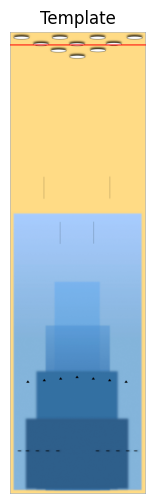

In [64]:
template = cv2.imread("intermediate_data/Template_lane_1.png")

h, w = template.shape[:2]
print(f"Template shape: {w}x{h}")

cv2.line(template, (0, 65), (w, 65), (0, 0, 255), 4)

showImage(template, "Template")

Original coordinates: (49, 1625)
Transformed coordinates: (316, 2086)


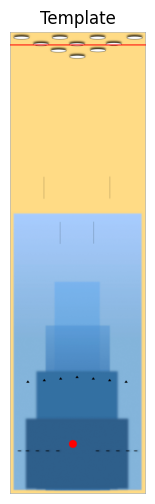

In [65]:
# Original and new image sizes
old_width, old_height = 106, 1829
new_width, new_height = w, h - 65

# Calculate scaling factors
scale_x = new_width / old_width
scale_y = new_height / old_height

# Extract the point (for example, the first point in the CSV file)
x_old, y_old = df.iloc[0][["x", "y"]]

# Transform the coordinates
x_new = int(x_old * scale_x)
y_new = int(y_old * scale_y) + 65

# Print original and transformed coordinates
print(f"Original coordinates: ({x_old}, {y_old})")
print(f"Transformed coordinates: ({x_new}, {y_new})")

cv2.circle(template, (x_new, y_new), 20, (0, 0, 255), -1)  # red dot
showImage(template, "Template")

In [66]:
def transform_coordinates():
    # Read CSV file
    df = pd.read_csv(CSV_POINTS_POSITIONS_FILE_PATH)

    # List to store the transformed points
    transformed_points = []

    # Iterate through each row and transform the coordinates
    for _, row in df.iterrows():
        x_old, y_old = row["x"], row["y"]

        # Transform coordinates
        x_new = int(x_old * scale_x)
        y_new = int(y_old * scale_y) + 65

        # Append the transformed point to the list
        transformed_points.append([row["frame"], x_new, y_new])

    # Create a new DataFrame with transformed coordinates
    transformed_df = pd.DataFrame(transformed_points, columns=["frame", "x", "y"])

    # Save the transformed coordinates to a new CSV file
    transformed_df.to_csv(CSV_POINTS_POSITIONS_DEFORMED_PATH, index=False)
    print(
        f"Transformed coordinates have been saved to: {CSV_POINTS_POSITIONS_DEFORMED_PATH}"
    )

In [67]:
transform_coordinates()

Transformed coordinates have been saved to: /home/davic/projects/IACV_project/bowling-analysis/data/auxiliary_data/reconstructed_positions/Transformed_positions_deformed_5.csv


When trasforming from lower to higher resolution I need to smooth the coordinates

In [68]:
def plot_coordinates(raw_df, cleaned_df):
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(6, 6))

    # Plot the original (raw) data on the left subplot
    axes[0].plot(raw_df["x"], -raw_df["y"], "o-", label="Trajectory", markersize=5)
    axes[0].set_title("Previous Ball Trajectory")
    axes[0].set_xlabel("X Coordinate")
    axes[0].set_ylabel("Y Coordinate")
    axes[0].legend()

    # Plot the cleaned data on the right subplot
    axes[1].plot(
        cleaned_df["x"], -cleaned_df["y"], "o-", label="Trajectory", markersize=5
    )
    axes[1].set_title("Processed Ball Trajectory")
    axes[1].set_xlabel("X Coordinate")
    axes[1].set_ylabel("Y Coordinate")
    axes[1].legend()

    # Adjust layout for better appearance
    plt.tight_layout()
    plt.show()

In [69]:
def Savitzky_Golay_filter(df, window_length=45, polyorder=2):
    df = df.copy()
    df["x"] = savgol_filter(df["x"], window_length=window_length, polyorder=polyorder)
    df["y"] = savgol_filter(df["y"], window_length=window_length, polyorder=polyorder)
    # Round the smoothed coordinates to integers
    df["x"] = df["x"].round().astype(int)
    df["y"] = df["y"].round().astype(int)

    return df

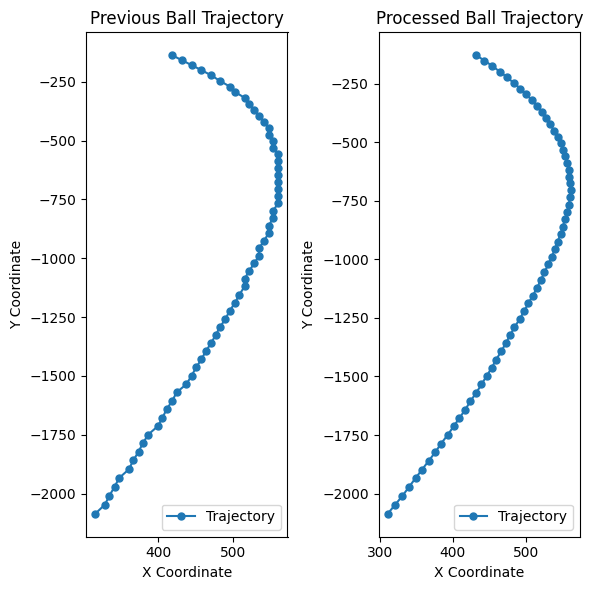

In [70]:
df = pd.read_csv(CSV_POINTS_POSITIONS_DEFORMED_PATH)
df_smooted = Savitzky_Golay_filter(df)
plot_coordinates(df, df_smooted)

In [71]:
# Save the smoothed DataFrame to a new CSV file
df_smooted.to_csv(CSV_POINTS_POSITIONS_DEFORMED_PATH, index=False)